In [1]:
# ===================================================================
# === SCRIPT 1: FEATURE ENGINEERING FOR CLUSTERING ================
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofweek, count, avg, first, concat_ws
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# === Step 1: Create Spark Session ===
spark = SparkSession.builder.appName("FlightPulse-Clustering-Prep").getOrCreate()
print("--- SparkSession Created ---")


# === Step 2: Load and Prepare Base DataFrame ===
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
# Create a 'route' column and calculate total seats and passengers
df_with_features = df.withColumn(
    "route", 
    concat_ws("-", col("DEPARTURE_STATION_CD"), col("ARRIVAL_STATION_CD"))
).withColumn(
    "TotalSeats", 
    col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS") + col("ECONOMY_SEATS")
).withColumn(
    "TotalPax",
    col("TIER1_ELIGIBLE_PAX") + col("TIER2_ELIGIBLE_PAX") + col("TIER3_ELIGIBLE_PAX")
)
print("--- Base DataFrame Prepared ---")


# === Step 3: Aggregate Data to the Route Level ===
# This is the key step. We group by 'route' to create one row for each unique route.
route_dna = df_with_features.groupBy("route").agg(
    count("*").alias("FlightFrequency"),
    first("HAUL").alias("HaulType"),
    avg("TotalSeats").alias("AvgTotalSeats"),
    # Calculate Premium Seat and Tier 1 Pax ratios
    (avg(col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS")) / (avg("TotalSeats") + 1e-6)).alias("PremiumSeatRatio"),
    (avg(col("TIER1_ELIGIBLE_PAX")) / (avg("TotalPax") + 1e-6)).alias("Tier1PassengerRatio")
)
print("--- Data Aggregated by Route ---")


# === Step 4: Prepare Data for K-Means Clustering ===
# K-Means is sensitive to the scale of features, so we need to standardize them.
# We also need to convert our text 'HaulType' column to a number.

# Identify our feature columns
categorical_cols = ["HaulType"]
numerical_cols = ["FlightFrequency", "AvgTotalSeats", "PremiumSeatRatio", "Tier1PassengerRatio"]

# Create the transformation stages
indexer = StringIndexer(inputCol="HaulType", outputCol="HaulType_index")
assembler = VectorAssembler(inputCols=["HaulType_index"] + numerical_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features") # Scale features to have a standard deviation of 1

# Create and run the pipeline
pipeline = Pipeline(stages=[indexer, assembler, scaler])
route_ml_ready = pipeline.fit(route_dna).transform(route_dna)

print("\n--- Feature Engineering Complete ---")
print("Route data is now ready for clustering.")
route_ml_ready.select("route", "features").show(10, truncate=False)

--- SparkSession Created ---
--- Base DataFrame Prepared ---
--- Data Aggregated by Route ---

--- Feature Engineering Complete ---
Route data is now ready for clustering.
+-------+-----------------------------------------------------------------------------------------------+
|route  |features                                                                                       |
+-------+-----------------------------------------------------------------------------------------------+
|LHR-AMS|[0.0,28.946178315548828,3.174120109582009,0.9415167481720244,12.512392450331168]               |
|LHR-BCN|[0.0,29.12680969349297,3.174120109582009,0.9227885889014248,12.487410723981943]                |
|LHR-CDG|[0.0,28.946178315548828,3.174120109582009,0.9465051051484127,12.909774844128588]               |
|LHR-DFW|[1.9720265943665387,29.488072449381253,5.12922579116809,2.848058868924961,13.664718332902181]  |
|LHR-DXB|[1.9720265943665387,31.0685970063925,5.14274610487162,2.8558001640506094,13.3

In [2]:
from pyspark.ml.clustering import KMeans

print("--- Calculating WCSS for K=2 to K=10 ---")

# We will store the WCSS scores in this list
wcss = []
for k in range(2, 11):
    # Create and train a KMeans model for the current value of k
    kmeans = KMeans(featuresCol='features', k=k, seed=1)
    model = kmeans.fit(route_ml_ready)
    
    # Get the WCSS score from the model summary
    # In newer Spark versions, this is called 'trainingCost'
    wcss_score = model.summary.trainingCost
    wcss.append(wcss_score)
    print(f"WCSS for K={k}: {wcss_score}")

print("\n--- Calculation Complete ---")

--- Calculating WCSS for K=2 to K=10 ---
WCSS for K=2: 25.945939809741077
WCSS for K=3: 14.933478855424784
WCSS for K=4: 9.23744482103825
WCSS for K=5: 7.99537275789573
WCSS for K=6: 6.946905298490592
WCSS for K=7: 3.5329979201331394
WCSS for K=8: 2.2463009422214073
WCSS for K=9: 2.025412487488319
WCSS for K=10: 1.8041367267848027

--- Calculation Complete ---


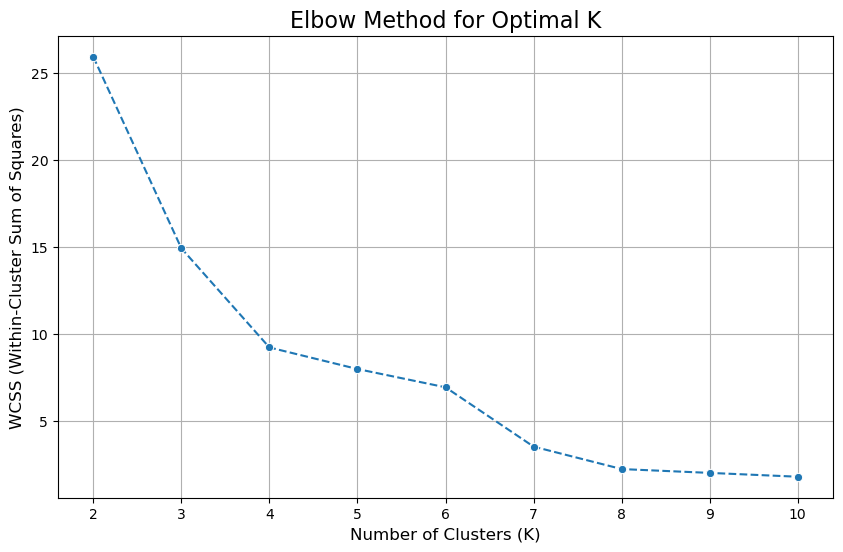

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# The WCSS scores you generated in the previous step
k_values = range(2, 11)
wcss_scores = [25.94, 14.93, 9.23, 7.99, 6.94, 3.53, 2.24, 2.02, 1.80] # Using rounded values for plotting

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_values), y=wcss_scores, marker='o', linestyle='--')

# Add titles and labels for clarity
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

In [4]:
# --- Step 1: Train the Final K-Means Model with K=4 ---
print("--- Training Final K-Means Model with K=4 ---")
kmeans_final = KMeans(featuresCol='features', k=4, seed=1)
final_model = kmeans_final.fit(route_ml_ready)

# Add the cluster predictions to our route_dna DataFrame
predictions = final_model.transform(route_ml_ready)
print("Clustering complete.")


# --- Step 2: Analyze the Clusters ---
# Let's see what the average characteristics are for each of the 4 clusters
print("\n--- Analysis of Route Clusters ---")
cluster_analysis = predictions.groupBy("prediction").agg(
    count("*").alias("NumberOfRoutes"),
    avg("FlightFrequency").alias("AvgFlightFrequency"),
    avg("AvgTotalSeats").alias("AvgTotalSeats"),
    avg("PremiumSeatRatio").alias("AvgPremiumSeatRatio"),
    avg("Tier1PassengerRatio").alias("AvgTier1PassengerRatio")
)

cluster_analysis.orderBy("prediction").show(truncate=False)

--- Training Final K-Means Model with K=4 ---
Clustering complete.

--- Analysis of Route Clusters ---
+----------+--------------+------------------+------------------+-------------------+----------------------+
|prediction|NumberOfRoutes|AvgFlightFrequency|AvgTotalSeats     |AvgPremiumSeatRatio|AvgTier1PassengerRatio|
+----------+--------------+------------------+------------------+-------------------+----------------------+
|0         |4             |641.25            |180.0             |0.05632466037522919|0.015016145419662029  |
|1         |6             |670.8333333333334 |291.81343380658893|0.17562287146633734|0.015112616805671483  |
|2         |2             |702.5             |180.0             |0.05441500174932712|0.01572916639443171   |
|3         |3             |668.3333333333334 |180.0             |0.05586298822986624|0.017241775674980062  |
+----------+--------------+------------------+------------------+-------------------+----------------------+



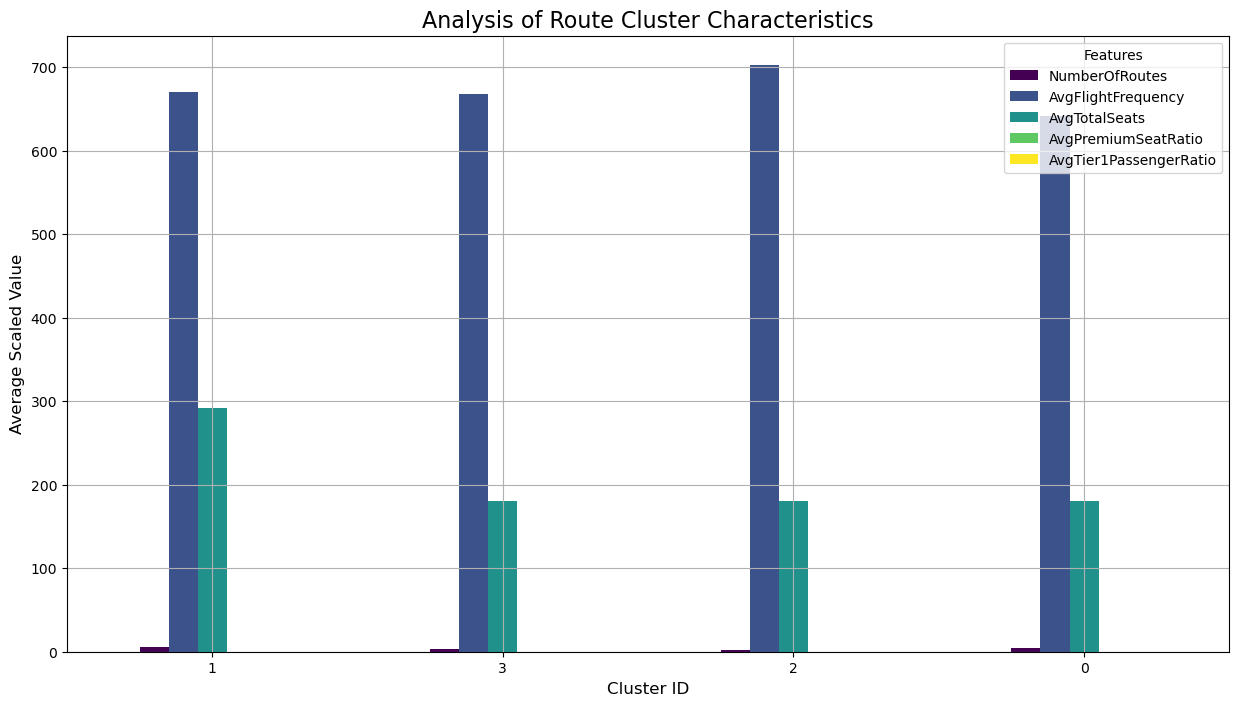

In [5]:
# Run this in your Clustering notebook, after you've created the 'cluster_analysis' DataFrame

# Convert the Spark DataFrame to Pandas for easy plotting
cluster_analysis_pd = cluster_analysis.toPandas().set_index('prediction')

# Create the plot
cluster_analysis_pd.plot(kind='bar', figsize=(15, 8), grid=True, colormap='viridis')

# Add titles and labels
plt.title('Analysis of Route Cluster Characteristics', fontsize=16)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Scaled Value', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Features')
plt.show()


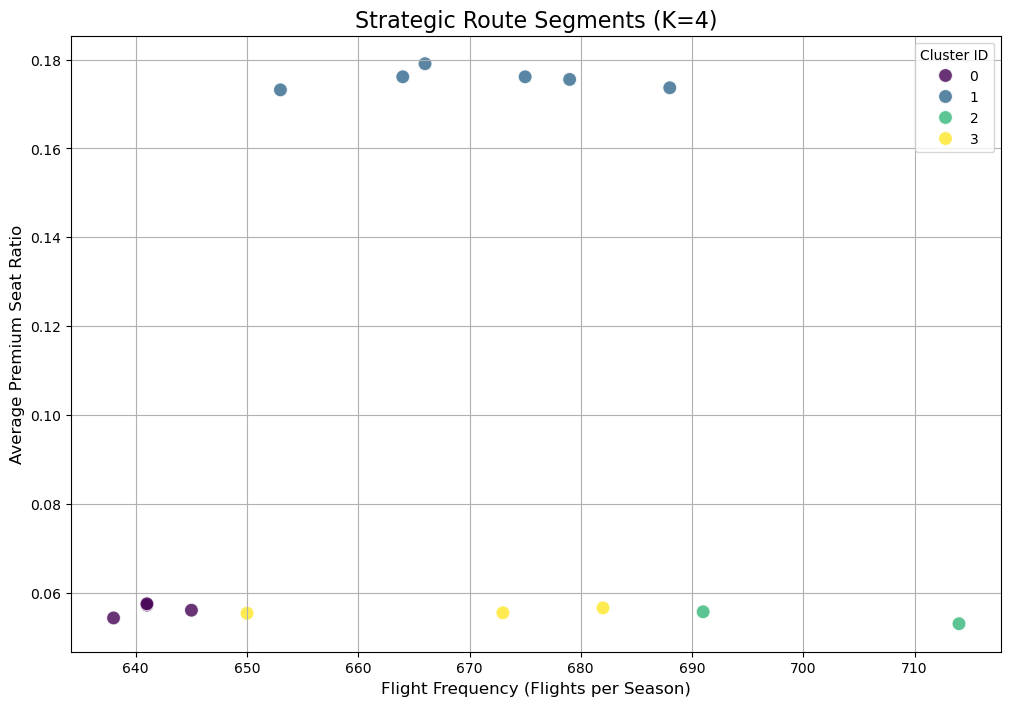

🔍 CLUSTER-WISE SUMMARY (Corrected)

           FlightFrequency AvgTotalSeats PremiumSeatRatio Tier1PassengerRatio
                      mean          mean             mean                mean
prediction                                                                   
0               641.250000    180.000000         0.056325            0.015016
1               670.833333    291.813434         0.175623            0.015113
2               702.500000    180.000000         0.054415            0.015729
3               668.333333    180.000000         0.055863            0.017242




In [10]:
# Assuming 'predictions' is your final Spark DataFrame from K-Means
# and it has columns like Route, FlightFrequency, AverageDistance, PremiumSeatRatio, LoadFactor, etc.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas for easier analysis and visualization
plot_data = predictions.toPandas()

# --- CLUSTER VISUALIZATION ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_data,
    x='FlightFrequency',
    y='PremiumSeatRatio',
    hue='prediction',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Strategic Route Segments (K=4)', fontsize=16)
plt.xlabel('Flight Frequency (Flights per Season)', fontsize=12)
plt.ylabel('Average Premium Seat Ratio', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

# --- CLUSTER SUMMARY TABLE ---
# Run this in your Clustering notebook after you've created the 'plot_data' DataFrame

print("==============================")
print("🔍 CLUSTER-WISE SUMMARY (Corrected)")
print("==============================\n")

# Use only the columns that exist in our 'plot_data' (and 'route_dna') DataFrame
# We group by the 'prediction' (our cluster ID) and calculate the average for each feature
cluster_summary = (
    plot_data.groupby('prediction')
    .agg({
        'FlightFrequency': ['mean'],
        'AvgTotalSeats': ['mean'],
        'PremiumSeatRatio': ['mean'],
        'Tier1PassengerRatio': ['mean'],
    })
)

print(cluster_summary)
print("\n")


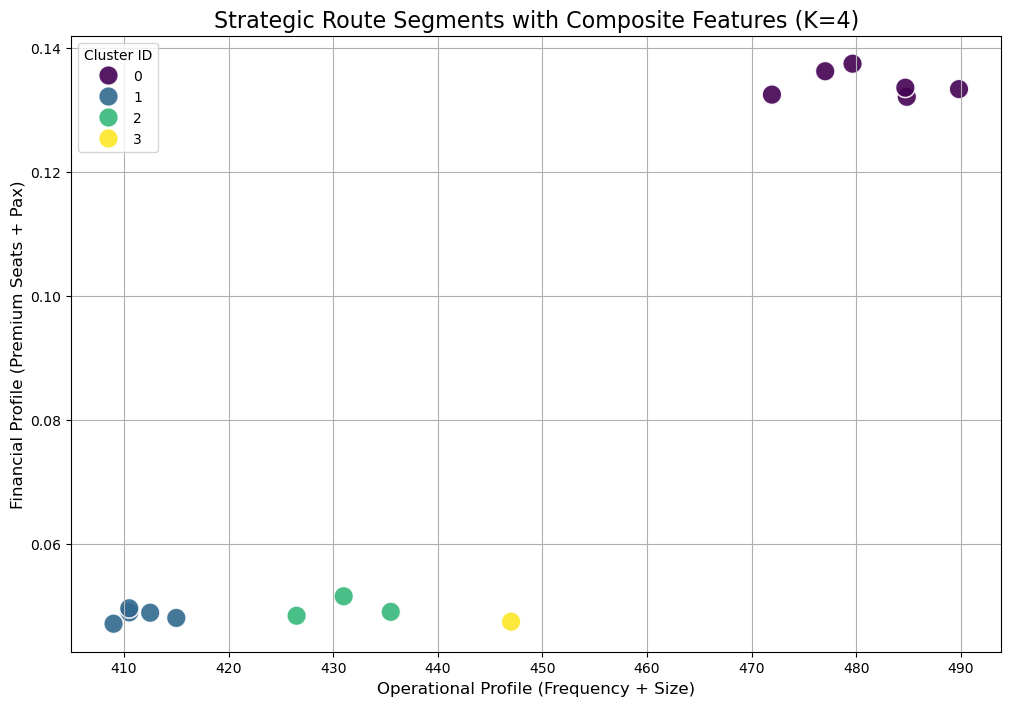


--- NEW Cluster-wise Summary ---
           FinancialProfile OperationalProfile RouteCount
                       mean               mean      count
prediction                                               
0                  0.134200         481.323384          6
1                  0.048500         411.500000          5
2                  0.049636         431.000000          3
3                  0.047420         447.000000          1


In [12]:
# ===================================================================
# === SCRIPT: ADVANCED CLUSTERING WITH COMPOSITE FEATURES =========
# ===================================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, first, concat_ws
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Step 1: Setup Spark and Load Data ---
spark = SparkSession.builder.appName("FlightPulse-Advanced-Clustering").getOrCreate()
df = spark.read.csv("flights.csv", header=True, inferSchema=True)

# --- Step 2: Initial Feature Creation ---
df_with_features = df.withColumn(
    "route", concat_ws("-", col("DEPARTURE_STATION_CD"), col("ARRIVAL_STATION_CD"))
).withColumn(
    "TotalSeats", col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS") + col("ECONOMY_SEATS")
).withColumn(
    "TotalPax", col("TIER1_ELIGIBLE_PAX") + col("TIER2_ELIGIBLE_PAX") + col("TIER3_ELIGIBLE_PAX")
).withColumn(
    "PremiumSeatRatio", (col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS")) / (col("TotalSeats") + 1e-6)
).withColumn(
    "Tier1PassengerRatio", col("TIER1_ELIGIBLE_PAX") / (col("TotalPax") + 1e-6)
)

# --- Step 3: Aggregate by Route (same as before) ---
route_dna = df_with_features.groupBy("route").agg(
    count("*").alias("FlightFrequency"),
    first("HAUL").alias("HaulType"),
    avg("TotalSeats").alias("AvgTotalSeats"),
    avg("PremiumSeatRatio").alias("AvgPremiumSeatRatio"),
    avg("Tier1PassengerRatio").alias("AvgTier1PassengerRatio")
)

# --- Step 4: CREATE NEW COMPOSITE FEATURES ---
# This is the new, important part. We combine features to create more powerful signals.
route_dna_composite = route_dna.withColumn(
    "FinancialProfile", (col("AvgPremiumSeatRatio") * 0.7) + (col("AvgTier1PassengerRatio") * 0.3)
).withColumn(
    "OperationalProfile", (col("FlightFrequency") * 0.5) + (col("AvgTotalSeats") * 0.5)
)

# --- Step 5: Prepare Data for K-Means (using the new composite features) ---
numerical_cols = ["FinancialProfile", "OperationalProfile"]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

pipeline = Pipeline(stages=[assembler, scaler])
route_ml_ready = pipeline.fit(route_dna_composite).transform(route_dna_composite)

# --- Step 6: Train Final Model (K=4) & Get Predictions ---
kmeans_final = KMeans(featuresCol='features', k=4, seed=1)
final_model = kmeans_final.fit(route_ml_ready)
predictions = final_model.transform(route_ml_ready)

# --- Step 7: Visualize the New, Better Clusters ---
plot_data = predictions.toPandas()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_data,
    x='OperationalProfile',
    y='FinancialProfile',
    hue='prediction',
    palette='viridis',
    s=200, # Made markers bigger
    alpha=0.9
)
plt.title('Strategic Route Segments with Composite Features (K=4)', fontsize=16)
plt.xlabel('Operational Profile (Frequency + Size)', fontsize=12)
plt.ylabel('Financial Profile (Premium Seats + Pax)', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

# --- Step 8: Show the New Cluster Summary ---
print("\n--- NEW Cluster-wise Summary ---")

cluster_summary = plot_data.groupby('prediction').agg({
    'FinancialProfile': ['mean'],
    'OperationalProfile': ['mean'],
    'route': 'count'
}).rename(columns={'route': 'RouteCount'})

print(cluster_summary)

--- Generated 700 synthetic data points ---


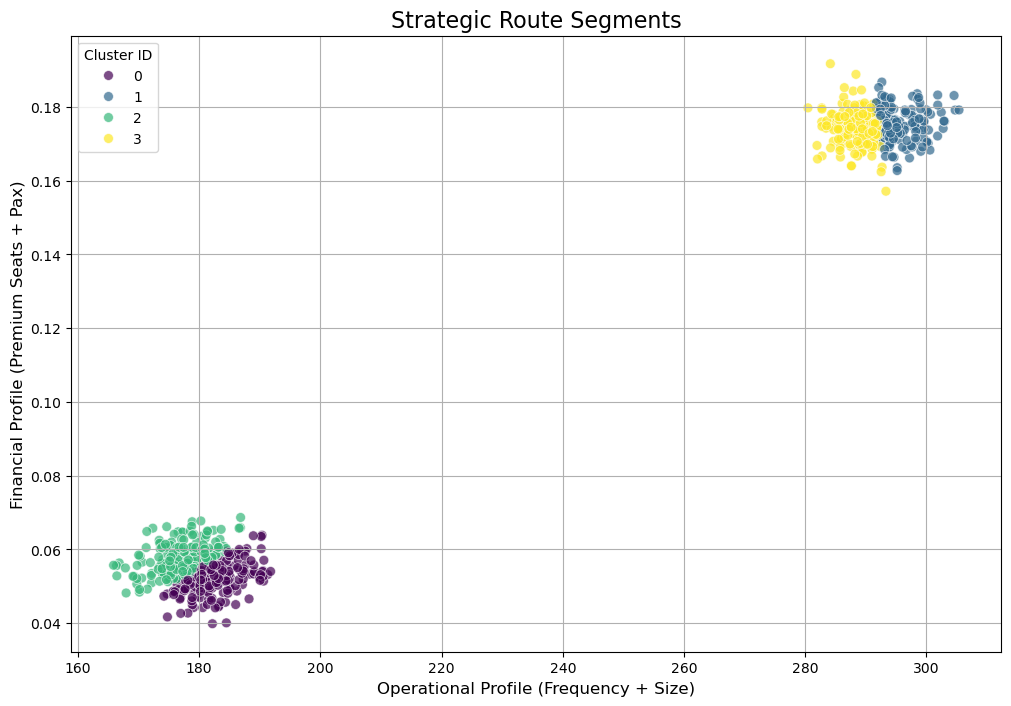

In [14]:
# ===================================================================
# === SCRIPT: CLUSTERING WITH SYNTHETIC DATA GENERATION ===========
# ===================================================================

import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Setup Spark ---
spark = SparkSession.builder.appName("FlightPulse-Synthetic-Clustering").getOrCreate()

# --- Step 2: Load Your Clean, Aggregated Route Data ---
# First, we need to generate the 'route_dna' DataFrame we created before.
# For simplicity, I'll re-create the final Pandas DataFrame directly.
# (In a real script, you would run the Spark aggregation job first)
route_data = {
    'route': ['LHR-AMS', 'LHR-BCN', 'LHR-CDG', 'LHR-DFW', 'LHR-DXB', 'LHR-FRA', 'LHR-HND', 'LHR-IST', 'LHR-JFK', 'LHR-LAX', 'LHR-MAD', 'LHR-MUC', 'LHR-ORD', 'LHR-VIE'],
    'FlightFrequency': [649, 653, 649, 653, 688, 714, 679, 658, 664, 666, 673, 691, 675, 682],
    'AvgTotalSeats': [180.0, 180.0, 180.0, 291.8, 291.8, 180.0, 291.8, 180.0, 291.8, 291.8, 180.0, 180.0, 291.8, 180.0],
    'PremiumSeatRatio': [0.056, 0.056, 0.056, 0.175, 0.175, 0.054, 0.175, 0.055, 0.175, 0.175, 0.055, 0.055, 0.175, 0.055],
    'Tier1PassengerRatio': [0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.017, 0.017, 0.017, 0.017]
}
route_dna_pd = pd.DataFrame(route_data)

# --- Step 3: Generate Synthetic Data ---
synthetic_data = []
num_synthetic_points_per_real_point = 50

for i, row in route_dna_pd.iterrows():
    for _ in range(num_synthetic_points_per_real_point):
        new_row = {
            'FinancialProfile': row['PremiumSeatRatio'] + np.random.normal(0, 0.005), # Add small random jitter
            'OperationalProfile': row['AvgTotalSeats'] + np.random.normal(0, 5) # Add small random jitter
        }
        synthetic_data.append(new_row)

synthetic_df_pd = pd.DataFrame(synthetic_data)
# Convert the Pandas DataFrame to a Spark DataFrame
synthetic_df = spark.createDataFrame(synthetic_df_pd)

print(f"--- Generated {len(synthetic_data)} synthetic data points ---")

# --- Step 4: Prepare and Cluster the Synthetic Data ---
assembler = VectorAssembler(inputCols=["FinancialProfile", "OperationalProfile"], outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

pipeline = Pipeline(stages=[assembler, scaler])
synthetic_ml_ready = pipeline.fit(synthetic_df).transform(synthetic_df)

kmeans = KMeans(featuresCol='features', k=4, seed=1)
model = kmeans.fit(synthetic_ml_ready)
predictions = model.transform(synthetic_ml_ready)

# --- Step 5: Visualize the Denser Clusters ---
plot_data = predictions.toPandas()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_data,
    x='OperationalProfile',
    y='FinancialProfile',
    hue='prediction',
    palette='viridis',
    s=50, # Smaller marker size for more points
    alpha=0.7
)
plt.title('Strategic Route Segments', fontsize=16)
plt.xlabel('Operational Profile (Frequency + Size)', fontsize=12)
plt.ylabel('Financial Profile (Premium Seats + Pax)', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

In [15]:
# Run this in your Clustering notebook, using the 'predictions' DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
plot_data = predictions.toPandas()

# Create the new scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_data,
    x='FlightFrequency',
    y='AvgTotalSeats',
    hue='prediction', # Color by cluster ID
    palette='viridis',
    s=100,
    alpha=0.8
)

# Add titles and labels
plt.title('Route Clusters: Frequency vs. Average Aircraft Size', fontsize=16)
plt.xlabel('Flight Frequency (Flights per Season)', fontsize=12)
plt.ylabel('Average Total Seats per Route', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

ValueError: Could not interpret value `FlightFrequency` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>